![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# XAI for Transformers: Attention Maps for Text

This Notebook shows how to produce attention maps for textual data. 

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. To start working on the notebook, click on the following button. This will open this page in the Colab environment, and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/xai-for-transformer/2-Tutorial_AttentionMaps_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Google Colab follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
A folder has been created in your Drive, and you can navigate it through the lefthand panel in Colab. You might also receive an email that informs you about the access on your Google Drive.

In [1]:
# Mount drive folder to dbe abale to download repo
# from google.colab import drive
# drive.mount('/content/drive')

# Switch to correct folder'
# %cd /content/drive/MyDrive

In [2]:
# Don't run this cell if you already cloned the repo 
# %rm -r XAI-Tutorials
# !git clone --branch main https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git

In [3]:
# Install al required dependencies and package versions
# %cd XAI-Tutorials
# !pip install -r requirements_xai-for-transformer.txt
# %cd xai-for-transformer

### Imports

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import zipfile
import requests

import sys  
sys.path.append('./')
import utils

%matplotlib inline

---

## Model Laoding

In the notebook [*1-Tutorial_Transformer_Model.ipynb*](./1-Tutorial_Transformer_Model.ipynb) we have fine-tuned a Seq2Seq model using the huggingface library to translate English to German.  
Since the fine-tuning takes some time, we will instead load the fine-tuned model with it's tokenizer and saved model weights.  
Therefore, please download the model weights folder and unzip it using the code below.

In [5]:
url = "https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/releases/download/v1.0.0/t5_small_weights.zip"
with open("../data/t5_small_weights.zip", "wb") as f:
    f.write(requests.get(url).content)

In [6]:
with zipfile.ZipFile("../data/t5_small_weights.zip", 'r') as zip_ref:
    zip_ref.extractall("../data/")

Once we downloaded the model weights, we set the path to the model weights folder and load the pre-trained model and tokenizer.

In [7]:
weights_path = "../data/t5_small_weights"

In [8]:
model = AutoModelForSeq2SeqLM.from_pretrained(weights_path)
tokenizer = AutoTokenizer.from_pretrained(weights_path)

Now let's translate a sentence from English to German: 

In [9]:
text = "Translate from English to German: I want to go to the cinema."

Let's generate the tokens for the input.

In [10]:
inputs = tokenizer(text, return_tensors="pt")
inputs

{'input_ids': tensor([[30355,    15,    45,  1566,    12,  2968,    10,    27,   241,    12,
           281,    12,     8, 10276,     5,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

The `input` variable is a dictionary containing two keys, input_ids and attention_mask. input_ids contains two rows of integers (one for each sentence) that are the unique identifiers of the tokens in each sentence. The attention_mask is a tensor that indicates which tokens should be attended to and which should not. It is usually a sequence of 1s and 0s: a 1 for each real token in input_ids and a 0 for padding tokens (if any). This tells the model to pay attention to the input tokens and ignore the padding in cases where sequences are padded to a fixed length for batched processing.

We generate the corresponding German translation of our English sentence. We can then generate the self-attention of the encoder, decoder, and cross attention.

In [11]:
output = model.generate(inputs.input_ids, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)
attention = model(**inputs, labels=output, output_attentions=True)

cross_attention = attention.cross_attentions
encoder_attention = attention.encoder_attentions
decoder_attention = attention.decoder_attentions

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


We can decode the input_ids of the input and output to generate their corresponding tokens 

In [12]:
decoded_input = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
decoded_input

['▁Translat',
 'e',
 '▁from',
 '▁English',
 '▁to',
 '▁German',
 ':',
 '▁I',
 '▁want',
 '▁to',
 '▁go',
 '▁to',
 '▁the',
 '▁cinema',
 '.',
 '</s>']

In [13]:
decoded_output = tokenizer.convert_ids_to_tokens(output[0])
decoded_output

['<pad>', '▁Ich', '▁will', '▁doch', '▁in', 's', '▁Kino', '▁gehen', '.', '</s>']

---

## Attention Maps for Text Models

Attention maps for text are visualizations that show how much focus a model places on different words or tokens in a sequence when making predictions. They highlight relationships between words by assigning attention weights, which indicate the importance of one word relative to others within the context of the task. Those attention weights can be generated from the self-attention or cross-attention mechanism.

**Please visit our [Introduction to Attention Maps](https://xai-tutorials.readthedocs.io/en/latest/_model_specific_xai/am.html#) to get more theoretical background information on how Attention Maps are calculated for different data modalities.**

***Note: we provide all references [here](https://xai-tutorials.readthedocs.io/en/latest/_model_specific_xai/am.html#references).***


### Attention Maps from Self-Attention

We can generate attention maps for the encoder or decoder side by averaging the heads of the last encoder/decoder layer and plot them.  
In such plots, lighter squares indicate higher average attention weights, suggesting that the model is considering those input positions more when encoding the word for translation.  
Darker squares, on the other hand, indicate lower average attention weights, suggesting that the model is less focused on those input positions when encoding the word.
If you see a strong diagonal line of lighter squares, it means that words are mostly attending to themselves and their immediate neighbors, which is typical as words often have the most context with adjacent words.  

Since this is the last encoder layer, the self-attention mechanism highlights how each word (or subword) in the input sequence attends to every other word (or subword). This is important for encoding the context around each word.  
What information can you retrieve from the encoder self-attention map?

/Users/lisasousa/Desktop/XAI-Tutorials/xai-for-transformer/utils.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([" "] + input_sentence, rotation=90)
/Users/lisasousa/Desktop/XAI-Tutorials/xai-for-transformer/utils.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([" "] + output_words)


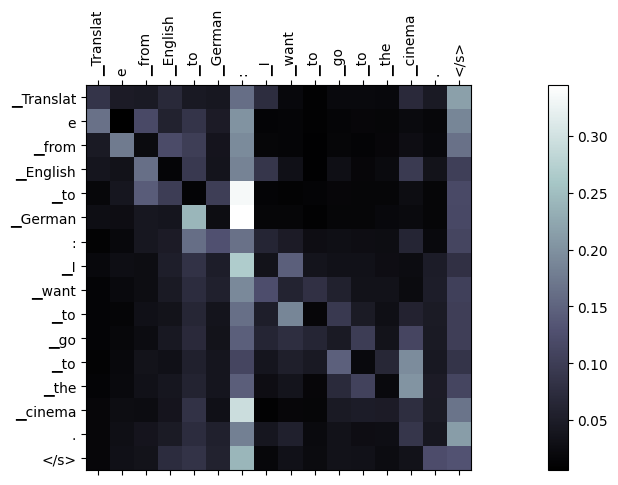

In [14]:
avg_encoder_attention = torch.stack(encoder_attention).mean(0).mean(1).squeeze(0)
utils.showAttention(decoded_input, decoded_input, avg_encoder_attention)

In the plot above, we can observe 

- **Off-Diagonal Attention**: Lighter squares away from the diagonal could indicate that the model is capturing long-range dependencies within the input sequence, which is crucial for understanding the full context of the sentence.
- **Special Tokens**: Attention to special tokens like $<s>$ and $</s>$ can indicate how the model handles the beginning and end of the input sequence.
- **Contextual Relationships**: By looking at which tokens have lighter squares in their row, you can infer which tokens are considered most important for understanding the context of other tokens.

We can generate the same plots for the decoder side, which allows us to understand how the model relates the different parts of the output sequence to each other.  
What information can you retrieve from the decoder self-attention map?

/Users/lisasousa/Desktop/XAI-Tutorials/xai-for-transformer/utils.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([" "] + input_sentence, rotation=90)
/Users/lisasousa/Desktop/XAI-Tutorials/xai-for-transformer/utils.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([" "] + output_words)


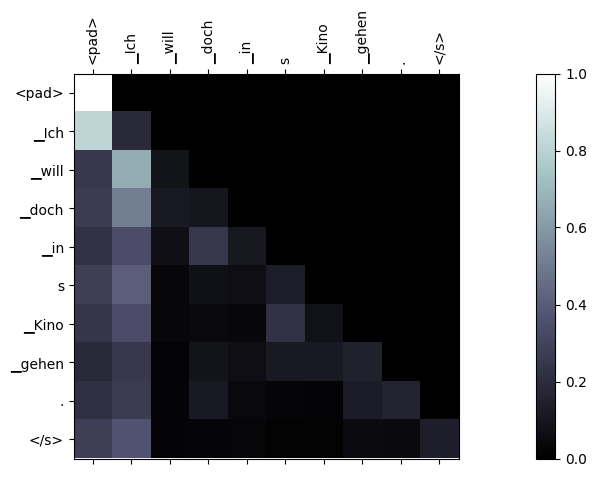

In [15]:
avg_decoder_attention = torch.stack(decoder_attention).mean(0).mean(1).squeeze(0)
utils.showAttention(decoded_output, decoded_output, avg_decoder_attention)

### Attention Maps from Cross-Attention

In cross-attention, the attention mechanism considers two different sequences. In our example, one sequence is the source sentence (the English sentence), and the other is the target sentence (the translated sentence).
A cross-attention map visualizes how elements of one sequence (English sentence) are attended to when processing each element of the other sequence (say, the target sentence). In other words, how much did each input token contribute to generating each output token?

To plot the cross attention, we average the heads of the last attention layer of the model and plot it.

/Users/lisasousa/Desktop/XAI-Tutorials/xai-for-transformer/utils.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([" "] + input_sentence, rotation=90)
/Users/lisasousa/Desktop/XAI-Tutorials/xai-for-transformer/utils.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([" "] + output_words)


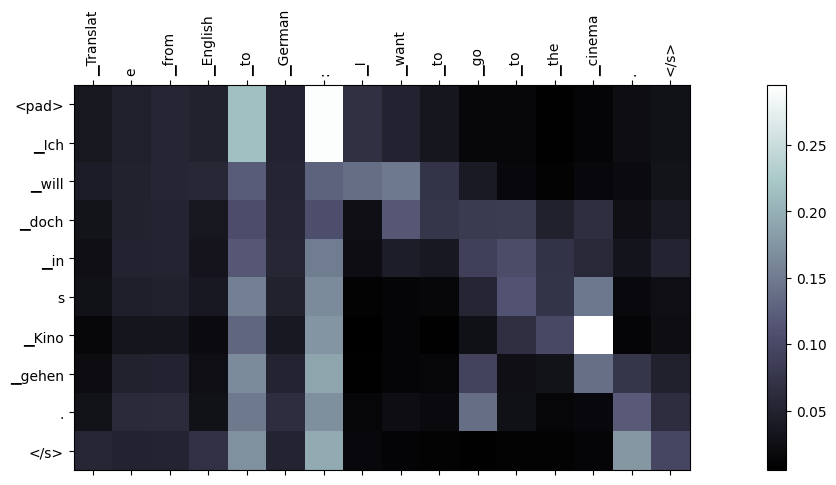

In [16]:
avg_attention = torch.stack(cross_attention).mean(0).mean(1).squeeze(0)
utils.showAttention(decoded_input, decoded_output, avg_attention)

In our example, you can see that there is a high attention between the tokens "cinema" and "Kino" and no attention between "want" and "Kino" for example.